# Ch01. 보험료 예측

---
[EDA 체크리스트]
1. 어떤 질문을 풀거나 틀렸다고 증명할 것인지
2. 중복된 항목 존재 유무
3. 어떤 종류의 데이터가 있으며 다른 데이터 타입들을 어떻게 다룰 것인지
4. 데이터에서 누락된 것이 있는지, 있다면 그것들을 어떻게 처리할 것인지
5. 이상치는 어디에 있으며, 관심을 가져야 할 데이터인지
6. 변수간 상관성이 있는지
---

In [ ]:
## 구글 드라이브 마운트가 필요할 시 주석 해제
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

#01. 데이터 탐색(EDA)
---

## 0. 데이터 불러오기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2. Data/[Ch01]Insurance premium prediction.csv')

## 1. 어떤 질문을 풀거나 틀렸다고 증명할 것인지
> 데이터 간략하게 확인

In [ ]:
# 데이터 프레임 형태 확인
print(df.shape)

(1338, 7)


In [ ]:
# 데이터 상단 15개 행 데이터 확인
print(df.head(15))

    age     sex     bmi  children smoker     region      charges
0    19  female  27.900         0    yes  southwest  16884.92400
1    18    male  33.770         1     no  southeast   1725.55230
2    28    male  33.000         3     no  southeast   4449.46200
3    33    male  22.705         0     no  northwest  21984.47061
4    32    male  28.880         0     no  northwest   3866.85520
5    31  female  25.740         0     no  southeast   3756.62160
6    46  female  33.440         1     no  southeast   8240.58960
7    37  female  27.740         3     no  northwest   7281.50560
8    37    male  29.830         2     no  northeast   6406.41070
9    60  female  25.840         0     no  northwest  28923.13692
10   25    male  26.220         0     no  northeast   2721.32080
11   62  female  26.290         0    yes  southeast  27808.72510
12   23    male  34.400         0     no  southwest   1826.84300
13   56  female  39.820         0     no  southeast  11090.71780
14   27    male     NaN  

* 고객ID 처럼 명백하게 보험료와 관계 없는 것은 무엇인지
* 컬럼 중 의미가 이해가지 않는 것은 없는지
* 약어나 전문 용어로 되어 있는 것은 없는지

## 2. 중복된 항목 존재 유무

In [ ]:
# 데이터 중복 항목수 확인
print('중복된 항목 수 :', len(df[df.duplicated()]))

중복된 항목 수 : 1


In [ ]:
# 중복된 항목 확인
print(df[df.duplicated(keep=False)])

# 중복된 항목 개수가 많을경우
# print(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)))

     age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631


In [ ]:
# 중복된 항목 제거
# ignore_index -> 중복 제거후 기존 index 무시
df.drop_duplicates(inplace=True, keep='first', ignore_index=True)

# 중복제거후 데이터 확인
df.shape

(1337, 7)

## 3. 어떤 종류의 데이터가 있으며 다른 데이터 타입들을 어떻게 다룰 것인지
> 총 컬럼수와 컬럼별 데이터 타입 확인

In [ ]:
# 데이터 컬림 이름/타입 정보 확인
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1332 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB
None


In [ ]:
# 데이터 타입별 컬럼수 확인
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ['Count', 'ColumnType']
dtype_df = dtype_df.groupby('ColumnType').aggregate('count').reset_index()
dtype_df

,ColumnType,Count
0,int64,2
1,float64,2
2,object,3


* 숫자형 데이터 중 명백하게 포함할 의미가 없는 것은 있는가
* 범주형 변수는 무엇이 있는가

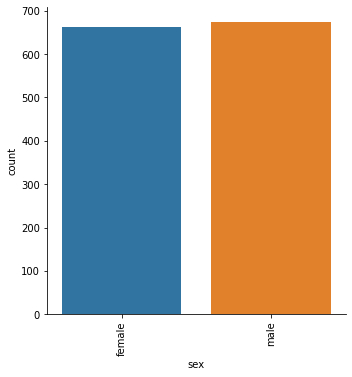

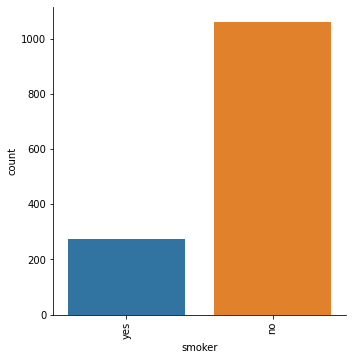

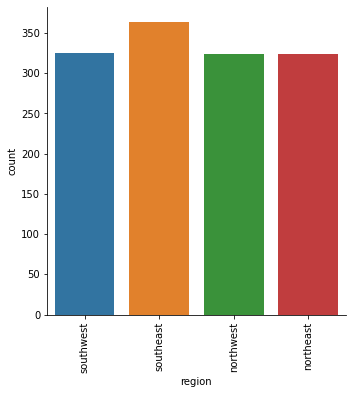

In [ ]:
# 범주형 변수별 개수 시각화
# category 타입은 없으나 list형태로 생성
for col in df.select_dtypes(include=['object', 'category']).columns:
  plot = sns.catplot(data=df, x=col, kind='count', hue=None)
  plot.set_xticklabels(rotation=90) # x의 label이 여러개 있을경우 겹치므로 세로로 출력
  plt.show()

In [ ]:
# 데이터 컬럼별 유일값 개수 확인
print(df.select_dtypes(include=['object', 'category']).nunique())

sex       2
smoker    2
region    4
dtype: int64


항목이 2개인 성별(sex)와 흡연여부(smoker)은 LabelEncoder, 지역(region)은 OneHotEncoder를 사용

> 범주형 변수 변환
- LabelEncoder : 각각의 범주를 서로 다른 점수로 맵핑
- OneHotEncoder : 각각의 범주를 0과 1로 맵핑

In [ ]:
## 성별(Sex) ##
sex = df.iloc[:, 1:2].values

le = LabelEncoder()

sex[:, 0] = le.fit_transform(sex[:, 0])
# fit_transform 이후 데이터 타입이 ndarray이므로 dataframe 타입 변환
sex = pd.DataFrame(sex)
# 타입 변환이후 컬럼명이 사라졌으므로 컬럼명 부여
sex.columns = ['sex']

# dict 형태로 변환
le_sex_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('성별에 대한 Label Encoder 결과 : ', le_sex_mapping, '\n', sex[:10])

성별에 대한 Label Encoder 결과 :  {'female': 0, 'male': 1} 
   sex
0   0
1   1
2   1
3   1
4   1
5   0
6   0
7   0
8   1
9   0


In [ ]:
## 흡연여부(Smoker) ##
smoker = df.iloc[:, 4:5].values

le = LabelEncoder()

smoker[:, 0] = le.fit_transform(smoker[:, 0])
smoker = pd.DataFrame(smoker)
smoker.columns = ['smoker']

le_smoker_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('흡연 여부에 대한 Label Encoder 결과 : ', le_smoker_mapping, '\n', smoker[:10])

흡연 여부에 대한 Label Encoder 결과 :  {'no': 0, 'yes': 1} 
   smoker
0      1
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0


In [ ]:
### 지역(region) ##
region = df.iloc[:, 5:6].values

ohe = OneHotEncoder()

region = ohe.fit_transform(region).toarray()
region = pd.DataFrame(region)

region.columns = ['northeast', 'northwest', 'southeast', 'southwest']
print("지역에 대한 OneHot Encoder 결과 : \n", region[:10])  

지역에 대한 OneHot Encoder 결과 : 
    northeast  northwest  southeast  southwest
0        0.0        0.0        0.0        1.0
1        0.0        0.0        1.0        0.0
2        0.0        0.0        1.0        0.0
3        0.0        1.0        0.0        0.0
4        0.0        1.0        0.0        0.0
5        0.0        0.0        1.0        0.0
6        0.0        0.0        1.0        0.0
7        0.0        1.0        0.0        0.0
8        1.0        0.0        0.0        0.0
9        0.0        1.0        0.0        0.0


## 4. 데이터에서 누락된 것이 있는지, 있다면 그것들을 어떻게 처리할 것인지
> Null값 포함 컬럼 찾기 -> 평균값으로 대체(Imputation 또는 보간법)

bmi    5
dtype: int64


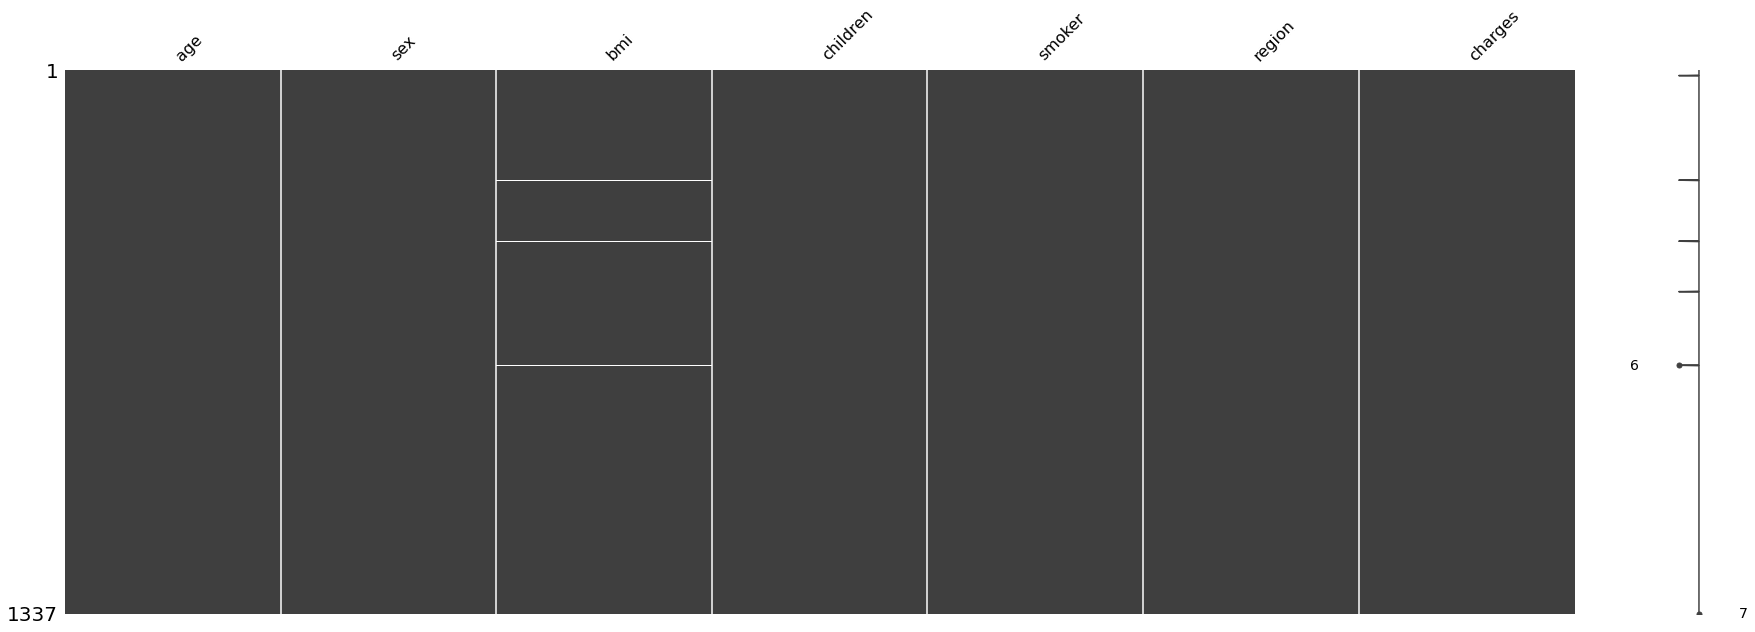

In [ ]:
# 각 컬럼별 몇 개의 Null값 포함 확인
count_nan = df.isnull().sum()
print(count_nan[count_nan > 0])

# issingno 패키지를 통해 시각화 확인
missingno.matrix(df, figsize=(30, 10))

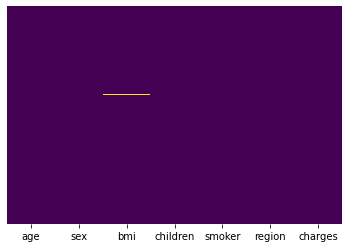

In [ ]:
# seaborn 패키지 heatmap을 통해 시각화 확인
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')

Series([], dtype: int64)


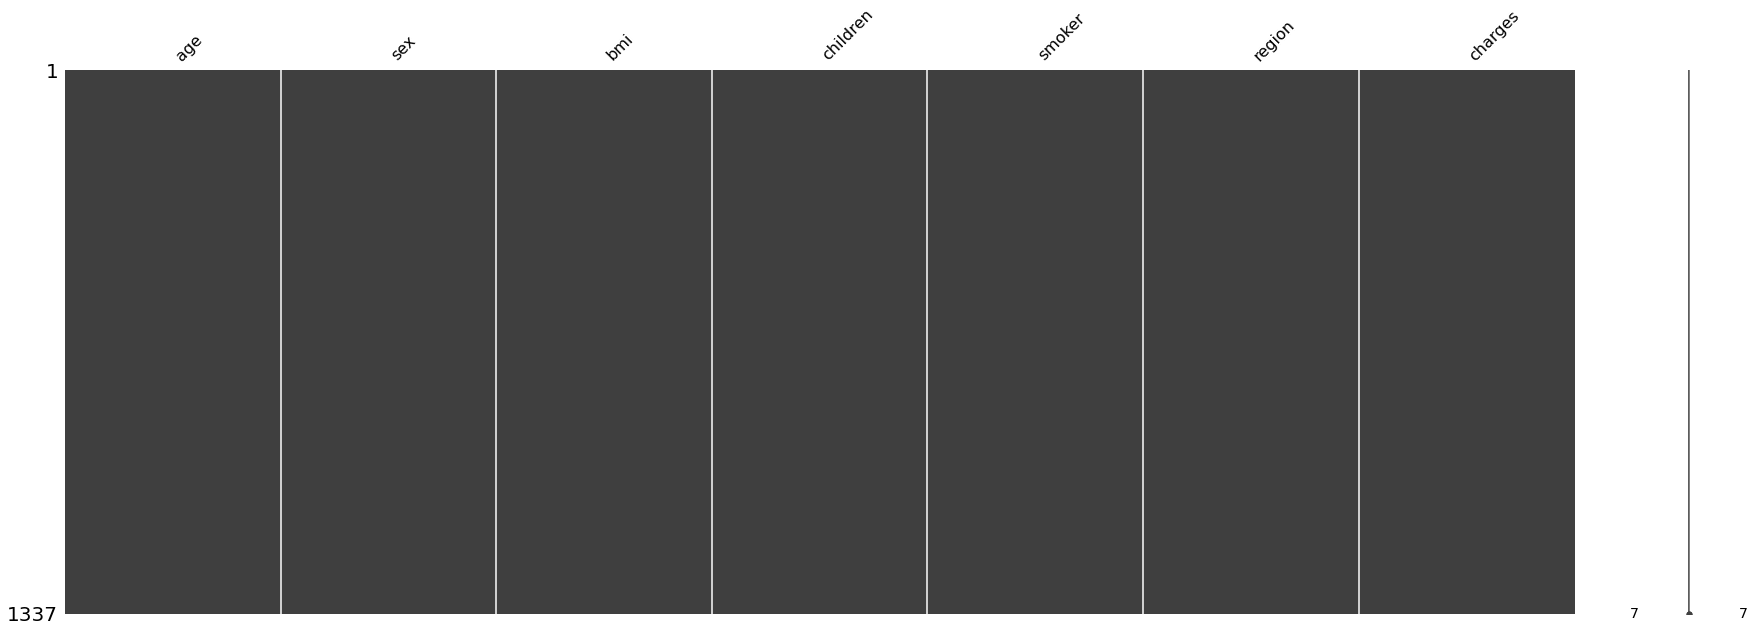

In [ ]:
# Null값 해당 컬럼의 평균값으로 대체
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

# 대체후 재확인
count_nan = df.isnull().sum()
print(count_nan[count_nan > 0])

# issingno 패키지를 통해 시각화 재확인
missingno.matrix(df, figsize=(30, 10))

* 결측값 처리 참고 사이트 : https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4

## 5. 이상치는 어디에 있으며, 관심을 가져야 할 데이터인지
> 숫자형 데이터별 요약 통계값 확인

In [ ]:
# 데이터 컬럼별 요약 통계값 보기
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.658596,6.083657,15.9600,26.315,30.4000,34.60000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


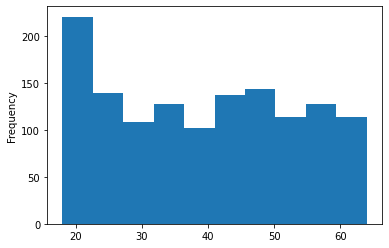

In [ ]:
# 데이터 개별 컬럼 히스토그램 확인
df.age.plot.hist()

> 숫자형 데이터 Skewness(비대칭도) 확인

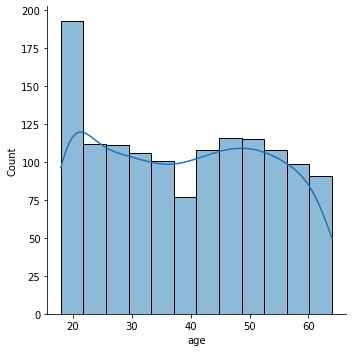

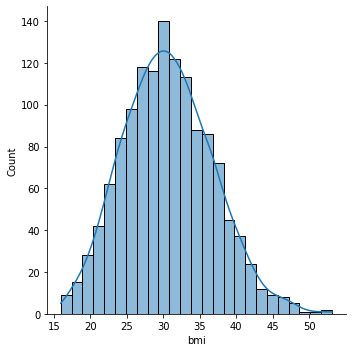

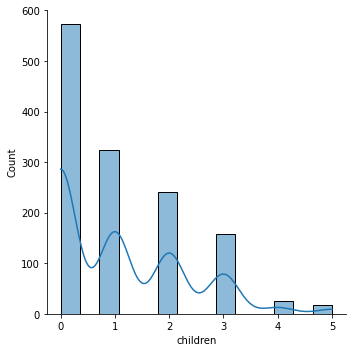

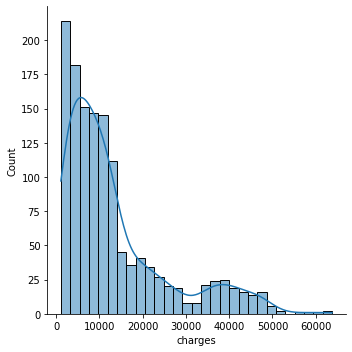

In [ ]:
# 데이터 컬럼 타입이 숫자형만 가져오기
num_df = df.select_dtypes(include=np.number)

# 데이터 컬럼 타입이 숫자형인 컬럼 이름 가져오기
num_list = num_df.columns.values
num_df_col = 4

# 컬럼별 히스토그램
for c in range(len(num_list)):
  sns.displot(num_df[num_list[c]], kde=True)

> 숫자형 데이터 BoxPlot 시각화

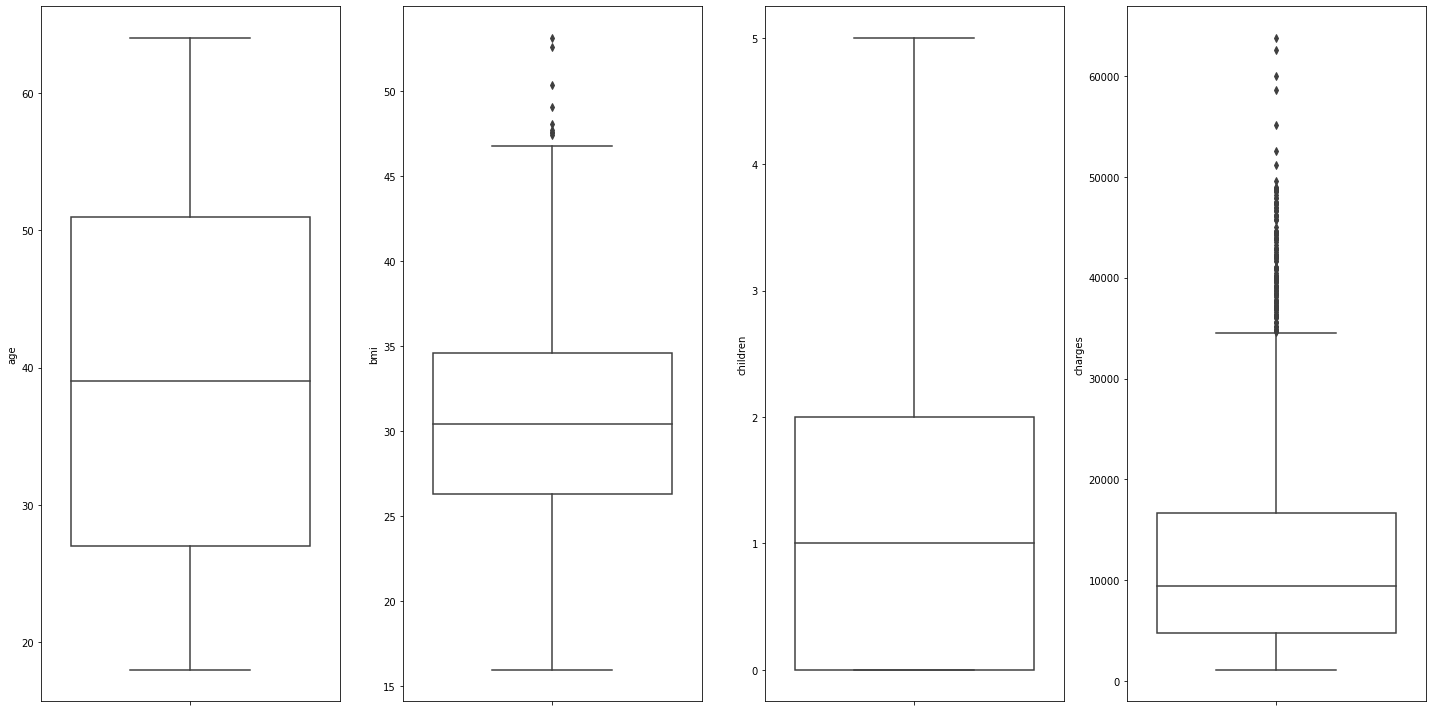

In [ ]:
# 데이터 컬럼 타입이 숫자형만 가져오기
columns = df.select_dtypes(include=np.number).columns

figure = plt.figure(figsize=(20,10))
figure.add_subplot(1, len(columns), 1)

for index, col in enumerate(columns):
  if index > 0:
    figure.add_subplot(1, len(columns), index + 1)
  sns.boxplot(y=col, data=df, boxprops={'facecolor': 'None'})

figure.tight_layout() # 자동으로 명시된 여백에 관련된 서브플롯 파마리터 조정
plt.show()

> 범주형 데이터 Violin Plot 시각화

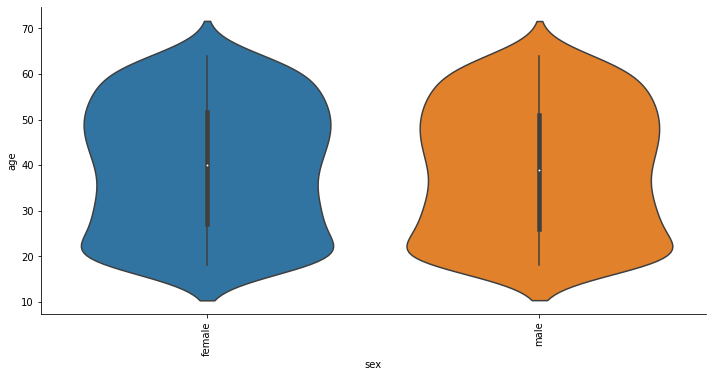

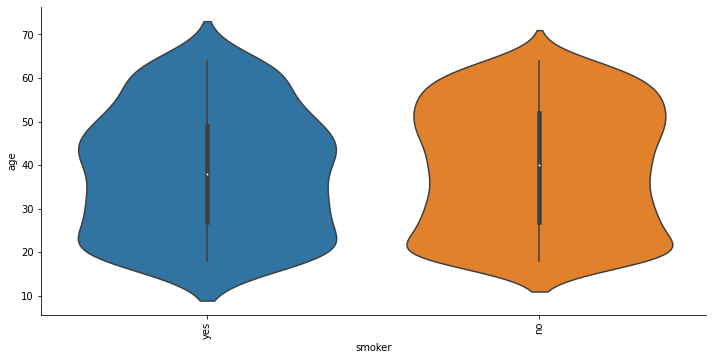

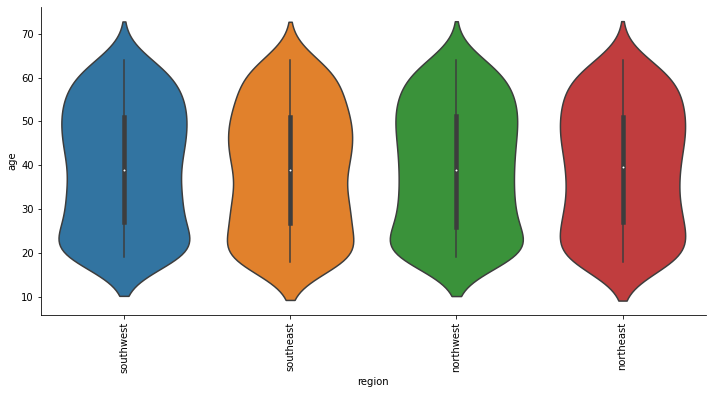

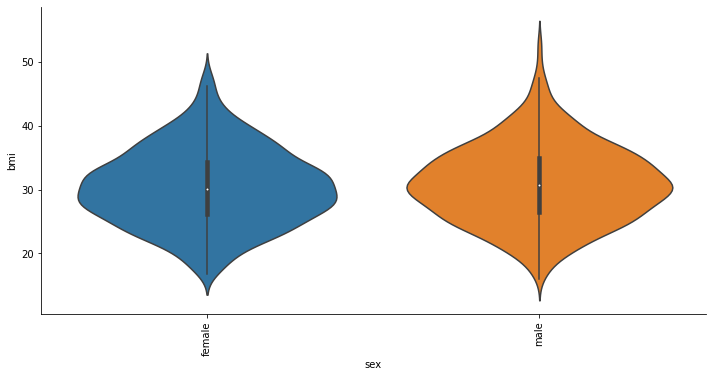

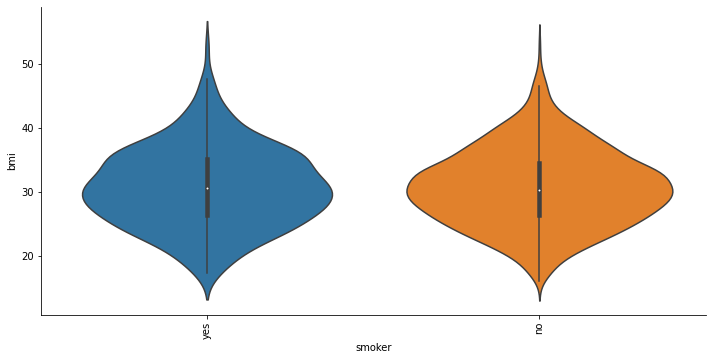

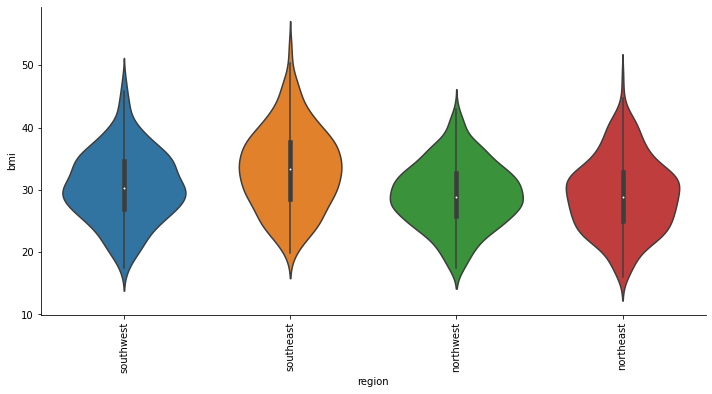

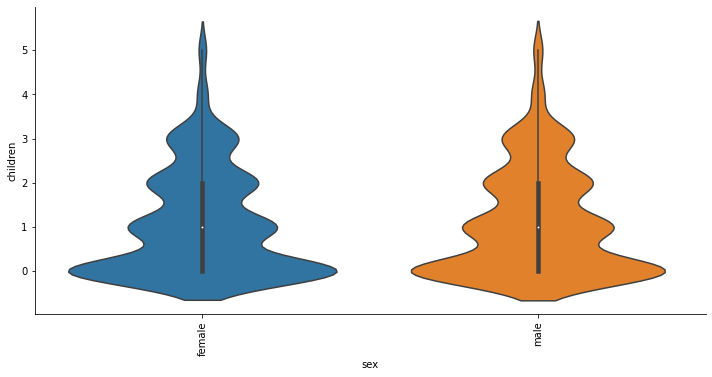

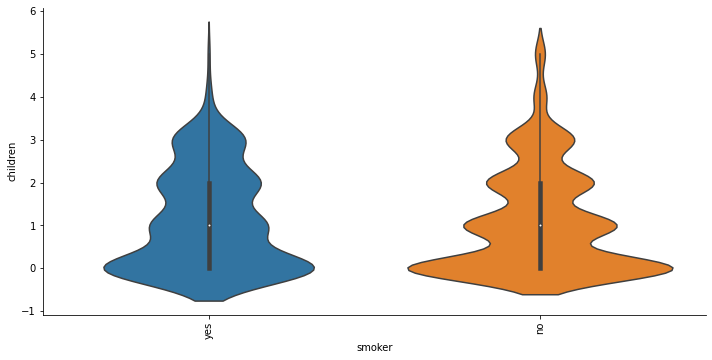

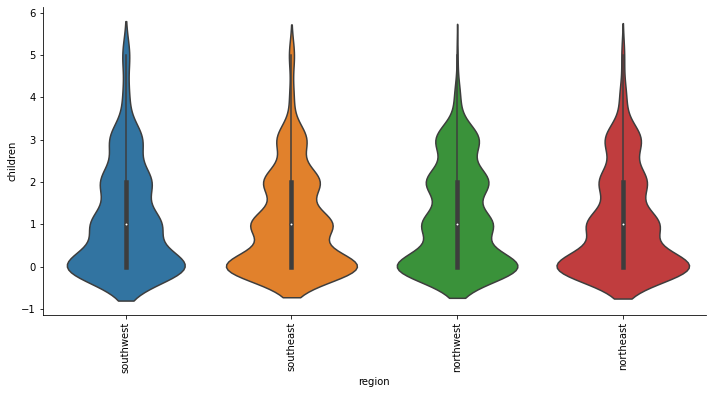

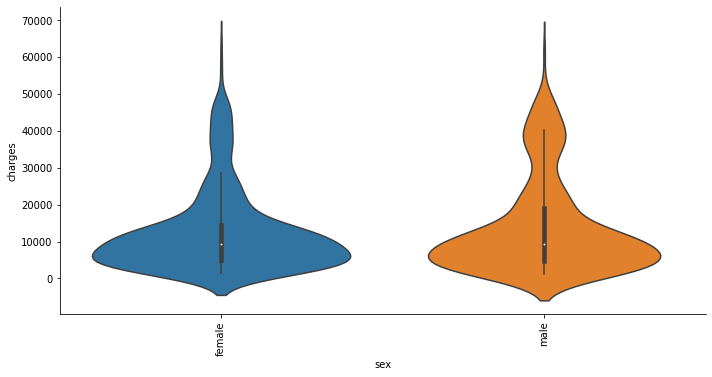

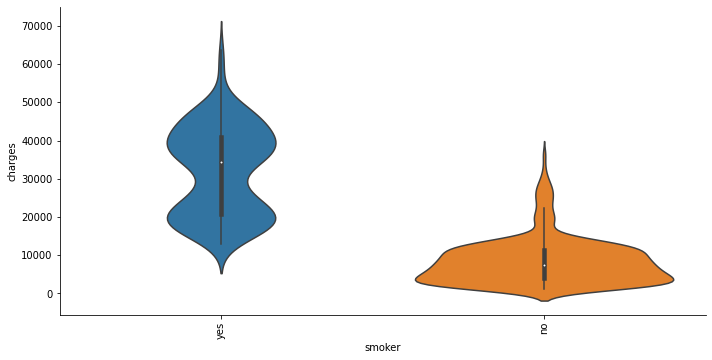

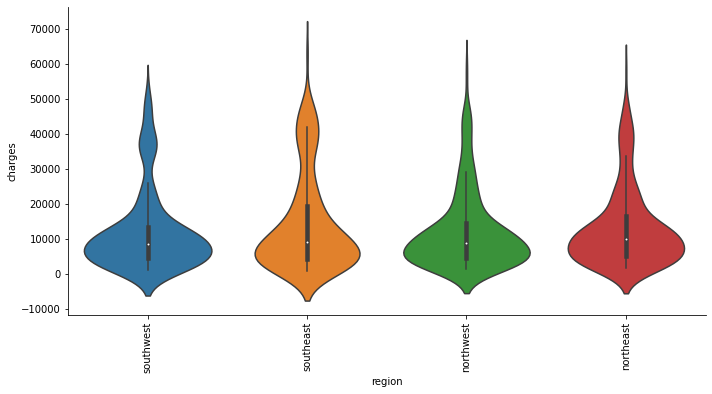

In [ ]:
if len(df.select_dtypes(include=['object', 'category']).columns) > 0: # 범주형 데이터가 한개라고 있으면 호출
  for col_num in df.select_dtypes(include=np.number).columns: # 숫자형 데이터
    for col in df.select_dtypes(include=['object','category']).columns: # 범주형 데이터
      plot = sns.catplot(data=df, x=col, y=col_num, kind='violin', height=5, aspect=2)
      plot.set_xticklabels(rotation=90)
      plt.show()

## 6. 변수간 상관성이 있는지
> 숫자형 데이터 간 Pairwise 결합 분포 시각화

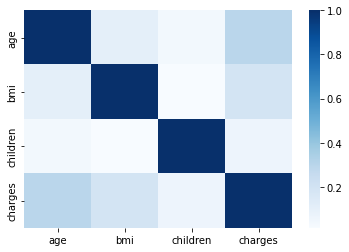

In [ ]:
# Seaborn Heatmap을 사용한 Correlation 시각화
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), cmap='Blues', annot=False)

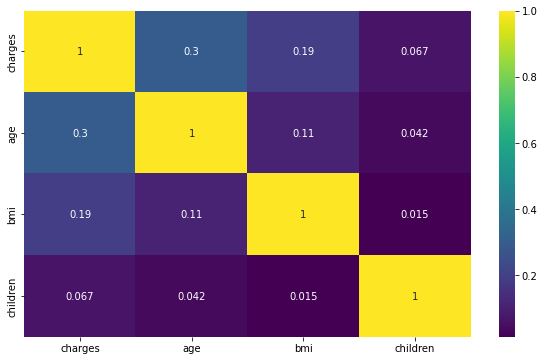

In [ ]:
# 보험료 Correlation Matrix 시각화
k = 4 # Heatmap 에서 확인한 변수 개수

# 보험료(charges)를 첫번째로 지정후 보험료와 상관도가 높은 변수를 순서대로 출력
cols = df.corr().nlargest(k, 'charges')['charges'].index
cm = df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

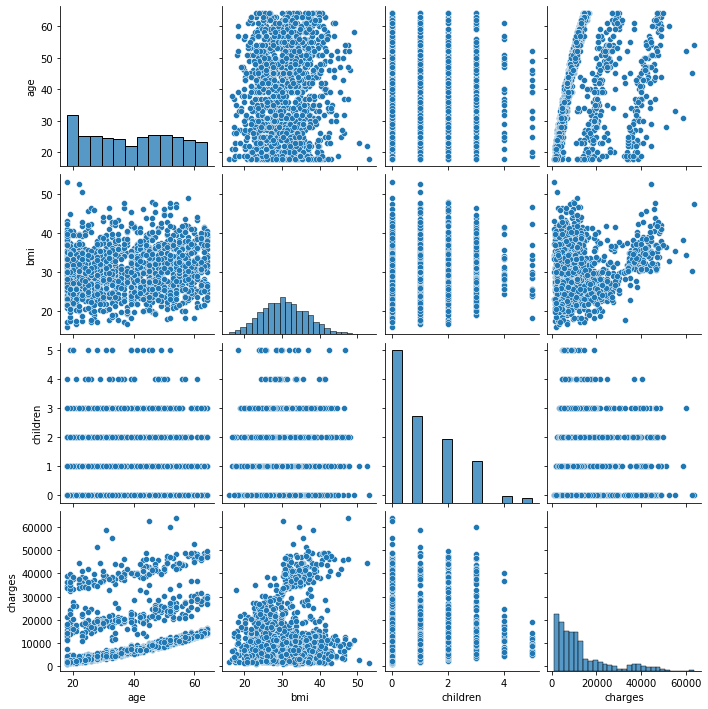

In [ ]:
# 숫자 변수형 컬럼들 간 Pairplot 그리기
sns.pairplot(df.select_dtypes(include=np.number))
plt.show()

> 범수형 데이터 기준 시각화

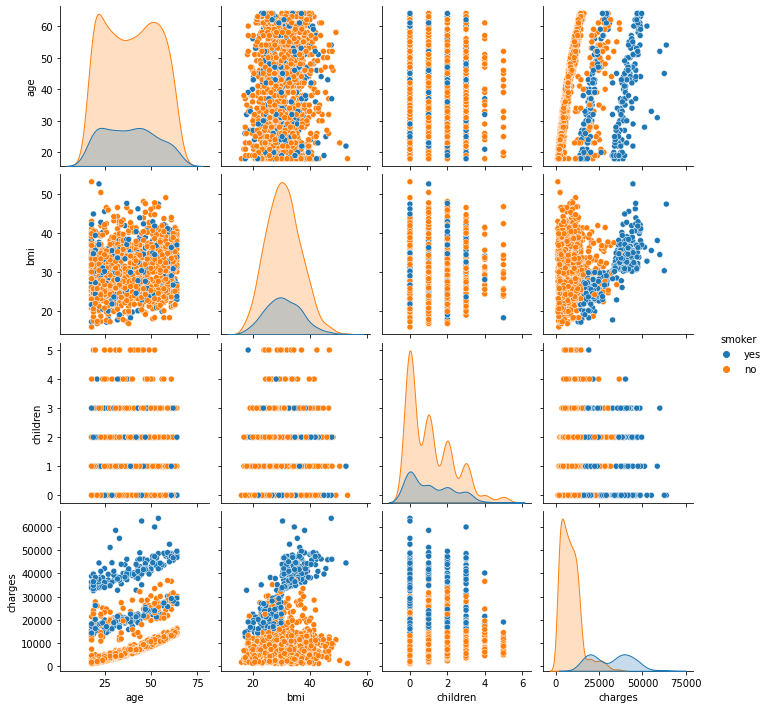

In [ ]:
# 흡연여부(smoker)컬럼 기준 시각화
hue = 'smoker'
sns.pairplot(df.select_dtypes(include=np.number).join(df[[hue]]), hue=hue)
plt.show()

#02. 다양한 Regression을 활용한 보험료 예측
---

### Train, Test 데이터 분리

In [ ]:
# 숫자형 데이터들만 복사
X_num = df[['age', 'bmi', 'children']].copy()

# 변환했던 범주형 데이터들과 결합
X_final = pd.concat([X_num, region, sex, smoker], axis=1)

# 보험료(Charges) 컬럼을 타겟값으로 설정
y_final = df[['charges']].copy()

# train, test epdlxj 2:1 비율로 분리
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=0)

In [ ]:
X_train[0:10]

,age,bmi,children,northeast,northwest,southeast,southwest,sex,smoker
905,27,32.585,3,1.0,0.0,0.0,0.0,1,0
2,28,33.000,3,0.0,0.0,1.0,0.0,1,0
405,52,38.380,2,1.0,0.0,0.0,0.0,0,0
481,49,37.510,2,0.0,0.0,1.0,0.0,1,0
338,50,32.300,1,1.0,0.0,0.0,0.0,1,1
356,46,43.890,3,0.0,0.0,1.0,0.0,1,0
1258,52,23.180,0,1.0,0.0,0.0,0.0,0,0
182,22,19.950,3,1.0,0.0,0.0,0.0,1,0
461,42,30.000,0,0.0,0.0,0.0,1.0,1,1
1058,32,33.820,1,0.0,1.0,0.0,0.0,1,0


In [ ]:
X_test[0:10]

,age,bmi,children,northeast,northwest,southeast,southwest,sex,smoker
1247,18,39.820,0,0.0,0.0,1.0,0.0,0,0
609,47,29.370,1,0.0,0.0,1.0,0.0,0,0
393,49,31.350,1,1.0,0.0,0.0,0.0,1,0
503,19,30.250,0,0.0,0.0,1.0,0.0,1,1
198,51,18.050,0,0.0,1.0,0.0,0.0,0,0
820,26,17.670,0,0.0,1.0,0.0,0.0,1,0
31,18,26.315,0,1.0,0.0,0.0,0.0,0,0
1250,19,19.800,0,0.0,0.0,0.0,1.0,1,0
1298,19,25.745,1,0.0,1.0,0.0,0.0,0,0
1150,58,36.480,0,0.0,1.0,0.0,0.0,0,0


### Feature Scaling
* 다차원의 값들을 비교 분석하기 쉽게 만든다
* 변수들 간의 단위 차이가 있을 경우 필요
* Overflow, Underfolw 방지

> Scaling 종류
* MinMaxScaler 사용 경우 : 이상치가 있는 경우 변환된 값이 매우 좁은 범위로 압축될 수 있음
* StandardScaler 사용 경우 : 이상치가 있는 경우에는 균형 잡힌 결과를 보장하기 힘듬
* RobustScaler 사용 경우 : 이상치의 영향을 최소화한 기법으로 중앙값과 IQR 을 사용하기 때문에 표준화 후 동일한 값을 더 넓게 분포시키게 함

In [ ]:
# MinMaxScaler
'''
n_scaler = MinMaxScaler()
X_train = n_scaler.fit_transform(X_train.astype(np.float))
X_test= n_scaler.transform(X_test.astype(np.float))
'''
# StandadrScaler
s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float))

### Regression 절차 요약
- Regression()
- fit()
- predict()
- score()

### Linear Regression 적용

In [ ]:
# fit model
lr = LinearRegression().fit(X_train, y_train)

# predict
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Score
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print('lr train score %.3f, lr test score: %.3f' % (lr.score(X_train,y_train), lr.score(X_test, y_test)))

lr.coef_: [[ 3.37463350e+03  1.65940982e+03  5.99333335e+02  1.86333968e+17
   1.88147678e+17  1.95299609e+17  1.91310259e+17 -1.29331244e+02
   9.54661747e+03]]
lr.intercept_: [13072.07173443]
lr train score 0.742, lr test score: 0.756


### Polynomial Regression 적용

In [ ]:
poly = PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(X_final)

X_train,X_test,y_train,y_test = train_test_split(X_poly,y_final, test_size = 0.33, random_state = 0)

# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

# fit model
poly_lr = LinearRegression().fit(X_train,y_train)

# predict
y_train_pred = poly_lr.predict(X_train)
y_test_pred = poly_lr.predict(X_test)

# Score
print('poly train score %.3f, poly test score: %.3f' % (poly_lr.score(X_train,y_train), poly_lr.score(X_test, y_test)))

poly train score 0.851, poly test score: 0.844


### Support Vector Regression 적용

In [ ]:
svr = SVR(kernel='linear', C = 300)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0 )

# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

# fit model
svr = svr.fit(X_train,y_train.values.ravel())
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

# Score
print('svr train score %.3f, svr test score: %.3f' % (svr.score(X_train,y_train), svr.score(X_test, y_test)))

svr train score 0.715, svr test score: 0.718


### RandomForest Regression 적용

In [ ]:
forest = RandomForestRegressor(n_estimators=100,
                              criterion='squared_error', # mse -> squared_error로 변경
                              random_state=1,
                              n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0 )

# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

# fit model
forest.fit(X_train,y_train.values.ravel())
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# Score
print('forest train score %.3f, forest test score: %.3f' % (forest.score(X_train, y_train), forest.score(X_test, y_test)))

forest train score 0.975, forest test score: 0.842


### Decision Tree Regression 적용

In [ ]:
dct = DecisionTreeRegressor(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0 )

# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

# fit model
dct = dct.fit(X_train,y_train.values.ravel())
y_train_pred = dct.predict(X_train)
y_test_pred = dct.predict(X_test)

# Score
print('dct train score %.3f, dct test score: %.3f' % (
dct.score(X_train,y_train),
dct.score(X_test, y_test)))

dct train score 0.999, dct test score: 0.701


### 다양한 모델 성능 종합 비교

In [ ]:
# 앞에서 만든 regressor 변수들과 라벨을 묶어서 하나의 리스트로 묶기
regressors = [(lr, 'Linear Regression'),
              (poly_lr, 'Polynomial Regression'),
              (svr, 'SupportVector Regression'),
              (forest, 'RandomForest Regression'),
              (dct, 'DecisionTree')]

# 각 regressor 변수들과 라벨 묶음을 차례로 fit -> predict -> score 로 처리해서 보여주기
for reg, label in regressors:
    print(80*'_', '\n')
    reg = reg.fit(X_train,y_train.values.ravel())
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)
    print(f'{label} train score %.3f, {label} test score: %.3f' % (reg.score(X_train,y_train), reg.score(X_test, y_test)))

________________________________________________________________________________ 

Linear Regression train score 0.742, Linear Regression test score: 0.756
________________________________________________________________________________ 

Polynomial Regression train score 0.742, Polynomial Regression test score: 0.756
________________________________________________________________________________ 

SupportVector Regression train score 0.715, SupportVector Regression test score: 0.718
________________________________________________________________________________ 

RandomForest Regression train score 0.975, RandomForest Regression test score: 0.842
________________________________________________________________________________ 

DecisionTree train score 0.999, DecisionTree test score: 0.701


#03. 결론
---
Training시에는 DecisionTree가 제일 성능이 좋지만,  
Testing시에는 RandomForest가 가장 좋은 성능이 나옴  
그러므로 의사결정에 필요한 모델로 RandomForest를 선택